In [10]:
import sys
sys.path.append('..')

from util import get_X_y_by_stock, get_tickers, get_currency_pair, load_latest_price_data, convert, add_features, load_pkl, merge_fred, remove_nan
from util import save_pkl, get_pipline_svr, get_pipline_rf

In [11]:
period = 256

In [12]:
data_dir = f'../processed_data_{period}/'

In [13]:
import logging

logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()
logger.info(f'Data loaded from {data_dir}...')

In [14]:
import logging
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the logger
logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

# Load the pickled data
def load_pkl(path):
    return pd.read_pickle(path)

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()

logger.info(f'Data loaded from {data_dir}...')



In [15]:
def combine_stock_gspc(df_stock_X, df_stock_y, df_gspc):
    # Get the later of the two start dates
    df_combined = df_stock_X.join(df_gspc, how='left')
    start_date = max(df_stock_X.index.min(), df_gspc.index.min())
    # Cut the combined dataframe to start from the later start date
    df_combined = df_combined.loc[start_date:]
    df_stock_y = df_stock_y.loc[start_date:]
    # Forward fill missing values in the 'predicted_gspc' column
    df_combined['predicted_gspc'] = df_combined['predicted_gspc'].ffill()
    # If there are still any NaN values at the beginning, you might want to back fill them
    df_combined['predicted_gspc'] = df_combined['predicted_gspc'].bfill()
    return df_combined, df_stock_y

In [16]:
import numpy as np

feature_names = list(df_train_X_all[0].columns)
coefficients = np.zeros(len(feature_names))
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]
    # concat the gspc data to the d_train_X_stock

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    #selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    # X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(df_train_X_stock, df_train_y_stock['log_predict'])

    # Get the coefficients of the selected features:
    coefficients += model.coef_

    # Mapping back to feature names (assuming you have a list of feature names)
    

feature_impact = dict(zip(feature_names, coefficients))

In [17]:
feature_impact

{'log_price_diff_1': -0.10413638107549418,
 'log_price_diff_2': -0.38612110483804324,
 'log_price_diff_4': -1.0533985979972298,
 'log_price_diff_8': -1.566347421891058,
 'log_price_diff_16': -2.0442837917479264,
 'log_price_diff_32': -3.3572198832483457,
 'log_price_diff_64': -7.140150987446723,
 'log_price_diff_128': -21.490926246815793,
 'log_price_diff_256': -13.322990102065333,
 'log_price_diff_512': -35.17236740812354,
 'log_M2SL_diff_1': 2.3955148811866898,
 'log_M2SL_diff_2': 0.7619080208001578,
 'log_M2SL_diff_4': 13.251898272841972,
 'log_M2SL_diff_8': 6.574798328846645,
 'log_M2SL_diff_16': 21.09933372820016,
 'log_M2SL_diff_32': -9.176366201413876,
 'UNRATE_diff_1': -0.1200327156050181,
 'UNRATE_diff_2': -3.9566667597272818,
 'UNRATE_diff_4': 15.30443151788648,
 'UNRATE_diff_8': -11.700175867154494,
 'UNRATE_diff_16': 20.549640429877815,
 'UNRATE_diff_32': -18.358040697377707,
 'FEDFUNDS_diff_1': 3.045814006821458,
 'FEDFUNDS_diff_2': 3.907092903614861,
 'FEDFUNDS_diff_4': 2

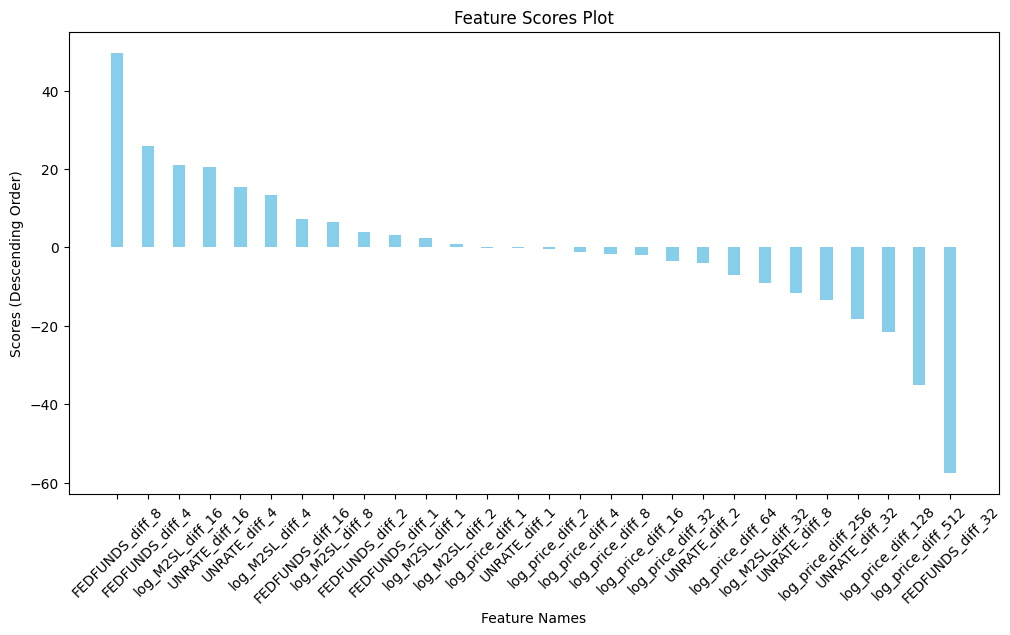

In [18]:
import matplotlib.pyplot as plt



# Assuming selector.scores_ is the array of scores for each feature
scores = coefficients

# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
feature_names = np.array(feature_names)
sorted_features = feature_names[sorted_scores]
sorted_scores = scores[sorted_scores]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_scores, color='skyblue',width=0.4)
plt.xlabel('Feature Names')
plt.ylabel('Scores (Descending Order)')
plt.title('Feature Scores Plot')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()

In [ ]:
scores = coefficients

# Get the scores in descending order
sorted_scores = np.abs(scores).argsort()[::-1]  # Sort indices in descending order of scores
feature_names = np.array(feature_names)
sorted_features = feature_names[sorted_scores]
sorted_features

In [ ]:
# write sorted_features to a file
with open(f'{data_dir}/sorted_features.txt', 'w') as f:
    for item in sorted_features:
        f.write("%s\n" % item)

In [ ]:
df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
  valid_tickers = f.read().splitlines()

with open(f'{data_dir}/sorted_features.txt', 'r') as f:
  sorted_features = f.read().splitlines()

In [ ]:
for i in range(len(valid_tickers)):
  df_train_X_stock = df_train_X_all[i]
  df_train_y_stock = df_train_y_all[i]
  df_test_X_stock = df_test_X_all[i]
  df_test_y_stock = df_test_y_all[i]
  df_train_X_stock, df_train_y_stock = combine_stock_gspc(df_train_X_stock, df_train_y_stock, df_gspc)
  df_test_X_stock, df_test_y_stock = combine_stock_gspc(df_test_X_stock, df_test_y_stock, df_gspc)


  df_train_X_all[i] = df_train_X_stock[sorted_features]
  df_test_X_all[i] = df_test_X_stock[sorted_features]


In [ ]:
df_train_X_all[0]

In [ ]:
import optuna
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from safeRegressors import TimeoutException

def objective_random_forest(trial, valid_tickers, df_train_X_all, df_train_y_all):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  n_estimators = trial.suggest_int('n_estimators', 20, 160)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  bootstrap = trial.suggest_categorical('bootstrap', [True, False])
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 6, 200)

  params = {"n_estimators": n_estimators, "max_depth": max_depth, \
            "min_samples_split": min_samples_split, \
              "min_samples_leaf": min_samples_leaf, "max_features": max_features, \
                "bootstrap": bootstrap, "max_leaf_nodes": max_leaf_nodes, "k": k}
  
  pipeline = get_pipline_rf(params)

  total_mses = 0
  try:
    for i in range(len(valid_tickers)):
      if i % 100 == 0:
        logger.info(f'Processing {i}th stock...')
      df_train_X = df_train_X_all[i]
      df_train_y = df_train_y_all[i]

      X_train = df_train_X.copy().values
      y_train = df_train_y.copy().values.ravel()
      predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=5)
      mse = mean_squared_error(y_train, predictions)
      total_mses += mse
    
    return total_mses/len(valid_tickers)
  except TimeoutException:
      logger.error("A timeout has occurred during model fitting.")
      # Return a large MSE value to penalize this result
      return float('inf')




study_rf = optuna.create_study()
study_rf.optimize(lambda trial: objective_random_forest(trial, valid_tickers, df_train_X_all, df_train_y_all), 
                    n_trials=10)

In [ ]:



# Iterate through the stocks and select the best features for each
tot_scores = None
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_new, df_train_y_stock['log_predict'])

    scores = selector.scores_

    # make element-wise addition for tot_scores
    if tot_scores is None:
        tot_scores = scores/len(valid_tickers)
    else:
        tot_scores += scores/len(valid_tickers)

# Get the scores in descending order
feature_names = df_train_X_all[0].columns
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = feature_names[sorted_scores]



In [ ]:
# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = df_train_X_stock.columns[sorted_scores]
print(sorted_features)

# iterate all tickers, reorder the features based on the scores by descending order
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_all[i] = df_train_X_all[i][sorted_features]



    # Now you have `selected_features_train` and `selected_features_test` which contain the selected features for the current stock.
    # You can continue with training or any further processing here

In [ ]:
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    print(df_train_X_stock.columns)
